In [1]:
import numpy as np
from scipy import signal

from skimage.data import stereo_motorcycle, moon, astronaut, camera
from skimage.transform import SimilarityTransform, warp

from skimage.color import rgb2gray
import matplotlib.pylab as plt
from skimage.filters import gaussian
#from skimage.registration import optical_flow_ilk as LK
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from skimage.transform import rescale

In [2]:
def display_image_pyr(imgs):
    N = len(imgs)
    m = int(np.sqrt(N))
    n = N // m
    if (m * n < N):
        m += 1
    fig = plt.figure(figsize=(8., 8.))

    for i, im in enumerate(imgs):
        fig.add_subplot(m, n, i + 1)
        plt.imshow(im, cmap='gray')
        plt.title("size: " + str(im.shape))

    plt.show(block=True)

def display_optic_flow(I1, I2, u, v, title=""):
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 4))

    # --- Sequence image sample

    ax0.imshow(I1, cmap='gray')
    ax0.set_title(r"$I_1$")
    ax0.set_axis_off()

    ax1.imshow(I2, cmap='gray')
    ax1.set_title(r"$I_2$")
    ax1.set_axis_off()

    nvec = 20  # Number of vectors to be displayed along each image dimension
    nl, nc = I1.shape
    step = max(nl // nvec, nc // nvec)

    y, x = np.mgrid[:nl:step, :nc:step]
    u_ = u[::step, ::step]
    v_ = v[::step, ::step]

    norm = np.sqrt(u ** 2 + v ** 2)
    angle = np.arctan2(v,u)
    ax2.imshow(angle)

    widths = np.linspace(0, 10, u.size)
    ax2.quiver(x, y, u_, v_, color='w', units='dots',
               angles='xy', scale_units='xy', lw=2, headaxislength=30, headlength=30, headwidth=15, edgecolors='w')#linewidth=2, edgecolors='w')
    ax2.set_title("Optical flow orientation and vector field")
    ax2.set_axis_off()
    fig.tight_layout()

    plt.suptitle(title)
    plt.show(block=True)


def get_real_sequence_image_pair(seq,t0,t1=None):

    assert seq in ['taxi','traffic','corridor'] # make sure the chosen sequence is available

    if t1 is None:
        t1 = t0 + 1 # if not provided the second frame, assume it is the following one

    valid_frame_ranges = {'taxi': [0, 40], 'traffic': [0, 48], 'corridor': [0, 9]}

    # make sure the chosen frames are available for the chosen sequence
    assert valid_frame_ranges[seq][1] >= t0 >= valid_frame_ranges[seq][0]
    assert valid_frame_ranges[seq][1] >= t1 >= valid_frame_ranges[seq][0]

    # read the corresponding frames
    I1, I2 = [Image.open("imgs-P6/" + seq + "/" + seq + "_frame" +
                         str(t).zfill(3) + ".png").convert('L') for t in [t0, t1]]

    # we can downscale for either computational reasons or to have smaller motions
    resize_factor = 0.5  # you can experiment with different values

    I1 = I1.resize([int(resize_factor * s) for s in I1.size])
    I2 = I2.resize([int(resize_factor * s) for s in I2.size])

    I1 = np.array(I1) / 255
    I2 = np.array(I2) / 255

    return I1, I2

def get_synthetic_sequence_image_pair(seq, translation=(0,0), rotation=0, scale=1):
    assert seq in ['moon','astronaut','camera'] # make sure the chosen sequence is available
    # moon: low-contrast image of the moon
    # astronaut: color image of astronaut
    # camera: gray-level image of cameraman
    image0 = eval(seq)()
    if (len(image0.shape) == 3):
        image0 = rgb2gray(image0)
    I1 = np.array(image0)
    if (I1.dtype == "uint8"):
        I1 = I1 / 255.0

    # apply synthetic transformation
    shift_y, shift_x = (np.array(I1.shape[:2]) - 1) / 2.  # image center
    tf_shift = SimilarityTransform(translation=[-shift_x, -shift_y])
    tf_shift_inv = SimilarityTransform(translation=[shift_x, shift_y])

    tf_transf = SimilarityTransform(scale= scale, rotation=np.deg2rad(rotation), translation=translation)
    I2 = warp(I1, (tf_shift + (tf_transf + tf_shift_inv)).inverse, preserve_range=True)

    return I1, I2


def display_magnitude_and_orientation(magnitude, angle):
    # display the magnitude of OF
    fig, ax = plt.subplots()
    plt.hist(magnitude[magnitude>0].flatten(), 30, label="LK, seq="+seq, fc=(0, 0, 1, 0.2))
    plt.legend()
    plt.show(block=True)

    # display the orientation of OF
    plt.imshow(angle,cmap='hsv') # cyclic maps: 'twilight', 'twilight_shifted', 'hsv'
    plt.title("Orientation")
    plt.show(block=True)

# Exercises 1 to 4

This exercises represent a series of steps to complete the computation of the optical flow.
The steps are the following:
1. Define temporal kernel.
2. Compute $A^TA$ and $A^Tb$
3. Use `np.linalg.lstsq(AtA, Atb)` to obtain u from $A^TAu=A^Tb$
4. Check that we are only calculating the optic flow $u$ if $A^TA$ is well-conditioned.

In [3]:
def optical_flow(I1g, I2g, window_size, tau=1e-2, bDisplay=False):

    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.ones((4,4))/16
    w = int(window_size/2) # window_size is odd, all the pixels with offset in between [-w, w] are inside the window

    I1g = gaussian(I1g, sigma=5, truncate=1/5)
    I2g = gaussian(I2g, sigma=5, truncate=1/5)

    # Implement Lucas-Kanade
    # for each image point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(I2g, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(I2g - I1g, kernel_t, boundary='symm', mode=mode)
    if bDisplay:
        for f in [fx,fy,ft]:
            plt.imshow(f,cmap='gray')
            plt.show(block=True)

    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)

    # iterate for each image window of size window_size * window_size
    M,N = I1g.shape
    for i in range(w, M-w):
        for j in range(w, N-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()

            A = np.concatenate([Ix.reshape(-1,1), Iy.reshape(-1,1)], axis=1)
            b = It.reshape(-1,1)

            AtA = np.matmul(A.T, A)
            Atb = np.matmul(A.T, b)

            # your code (4)

            if np.min(np.linalg.eigvals(AtA)) > tau and np.linalg.matrix_rank(AtA) == 2: 
                nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
                u[i,j]=nu[0]
                v[i,j]=nu[1]

    return u,v

In [4]:
I1, I2 = get_real_sequence_image_pair('taxi',30, 32)

In [5]:
scale = 1 # 1=no change, >1: zoom in, <1: <zoom out (e.g.
rotation = -30.0 # in degrees, positive or negative for clockwise or counter-clockwise, respectively
translation = (0.0, 0.0) # (tx, ty) in pixel, positive or negative
I1, I2 = get_synthetic_sequence_image_pair('camera', translation=translation, rotation=rotation, scale=scale)


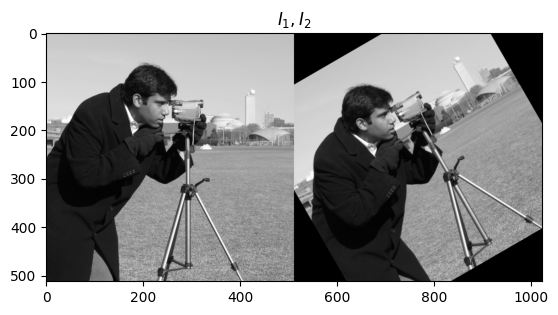

In [6]:
# display the images before computing the optic flow
plt.title(r"$I_1, I_2$")
plt.imshow(np.hstack((I1,I2)),cmap='gray')
plt.show(block=True)

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


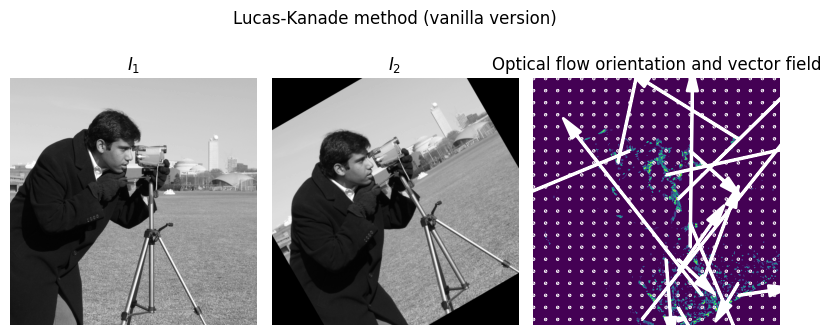

In [7]:
window_size = 3
tau = 0.01
u,v = optical_flow(I1, I2, window_size=window_size, tau=tau)
display_optic_flow(I1, I2, -u, -v, "Lucas-Kanade method (vanilla version)")

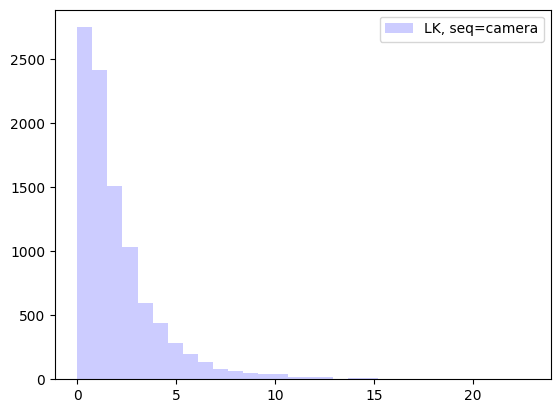

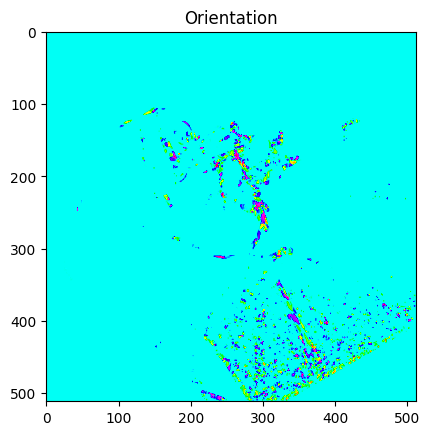

In [8]:
seq='camera'
magnitude = np.sqrt(u ** 2 + v ** 2)
angle = np.arctan2(v,u)
display_magnitude_and_orientation(magnitude, angle)

# Exercise 5

This exercise is tricky. I tried different values of translation but in reallity the algorithm will still work, the only problem is that the optical flow makes no sense in the parts of the image that do not exist anymore after translation and also as the optical flow is something local it might start to do strnage things if the translation is greater than the window were it is calculated based on its locallity.

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]
/home/leo/VCodeProjects/Computer Vision/lab6/.venv/lib64/python3.11/site-pac

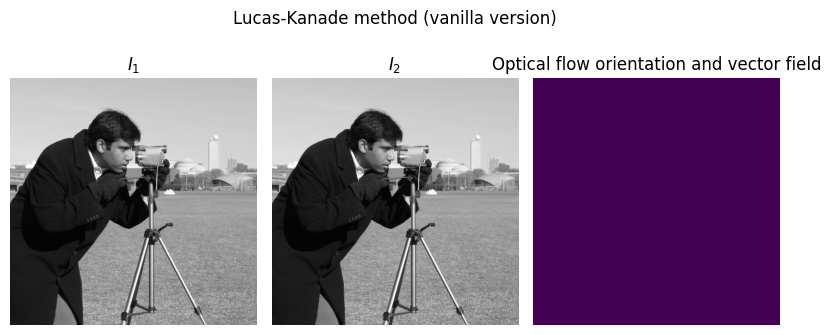

In [9]:
scale = 1 # 1=no change, >1: zoom in, <1: <zoom out (e.g.
rotation = 0 # in degrees, positive or negative for clockwise or counter-clockwise, respectively
translation = (0.0, 0.0) # (tx, ty) in pixel, positive or negative
I1, I2 = get_synthetic_sequence_image_pair('camera', translation=translation, rotation=rotation, scale=scale)
window_size = 20
tau = 0.01
u,v = optical_flow(I1, I2, window_size=window_size, tau=tau)
display_optic_flow(I1, I2, -u, -v, "Lucas-Kanade method (vanilla version)")

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


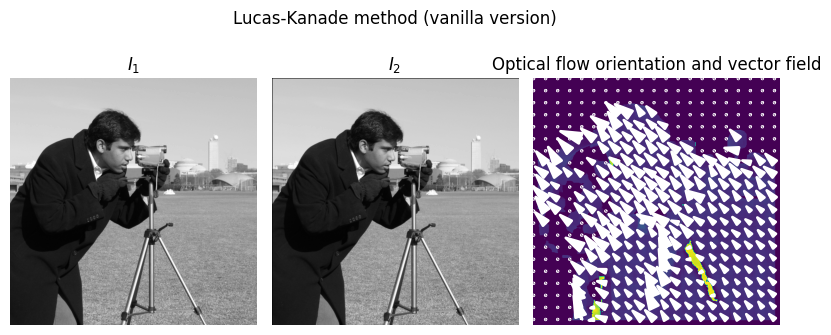

In [10]:
scale = 1 # 1=no change, >1: zoom in, <1: <zoom out (e.g.
rotation = 0 # in degrees, positive or negative for clockwise or counter-clockwise, respectively
translation = (1.0, 1.0) # (tx, ty) in pixel, positive or negative
I1, I2 = get_synthetic_sequence_image_pair('camera', translation=translation, rotation=rotation, scale=scale)
window_size = 20
tau = 0.01
u,v = optical_flow(I1, I2, window_size=window_size, tau=tau)
display_optic_flow(I1, I2, -u, -v, "Lucas-Kanade method (vanilla version)")

You can see the purple region with circles that makes no sense for the optical flow calculation and that the flow does not correspond with the direction of the translation.

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


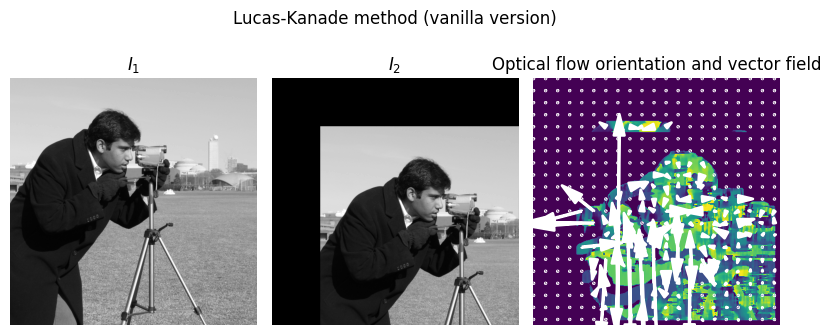

In [11]:
scale = 1 # 1=no change, >1: zoom in, <1: <zoom out (e.g.
rotation = 0 # in degrees, positive or negative for clockwise or counter-clockwise, respectively
translation = (100.0, 100.0) # (tx, ty) in pixel, positive or negative
I1, I2 = get_synthetic_sequence_image_pair('camera', translation=translation, rotation=rotation, scale=scale)
window_size = 20
tau = 0.01
u,v = optical_flow(I1, I2, window_size=window_size, tau=tau)
display_optic_flow(I1, I2, -u, -v, "Lucas-Kanade method (vanilla version)")

# Exercise 6

The function plot_optic_flow() just display arrows pointing in the direction and with the maginitude of the optic flow and the colours are just the representation of the optical flow angle. That is done using the following two lines of code:
``` # To show the angles of the optical flow.
angle = np.arctan2(v,u)
ax2.imshow(angle)

# To show the arrows pointing in the directioon and with the magnitude of the optical flow.
ax2.quiver(x, y, u_, v_, color='w', units='dots', angles='xy', scale_units='xy', lw=2, headaxislength=30, headlength=30, headwidth=15, edgecolors='w')
```

# Exercise 7

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


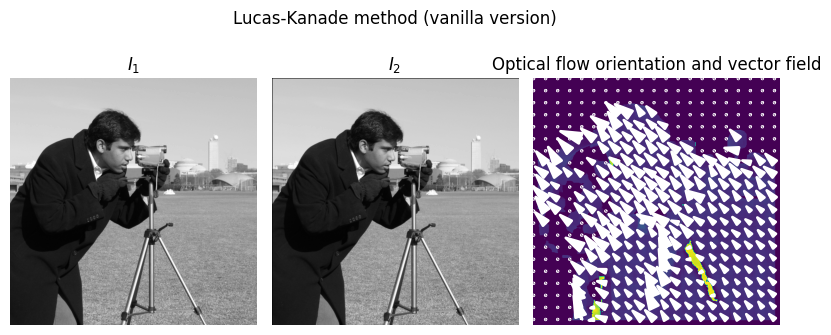

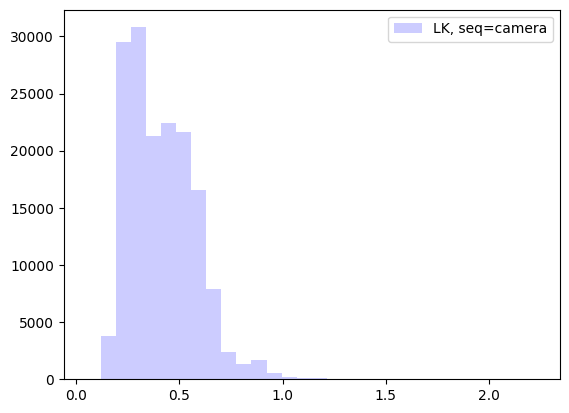

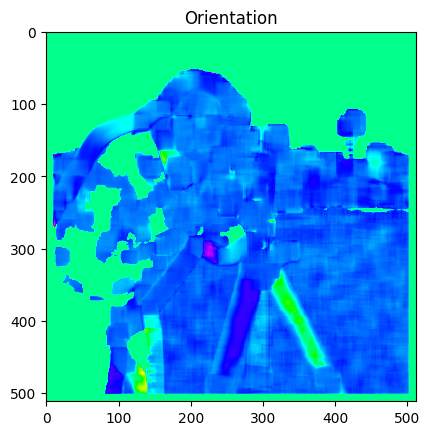

In [12]:
scale = 1 # 1=no change, >1: zoom in, <1: <zoom out (e.g.
rotation = 0 # in degrees, positive or negative for clockwise or counter-clockwise, respectively
translation = (1.0, 1.0) # (tx, ty) in pixel, positive or negative
I1, I2 = get_synthetic_sequence_image_pair('camera', translation=translation, rotation=rotation, scale=scale)
window_size = 20
tau = 0.01
u,v = optical_flow(I1, I2, window_size=window_size, tau=tau)
display_optic_flow(I1, I2, -u, -v, "Lucas-Kanade method (vanilla version)")
magnitude = np.sqrt(u ** 2 + v ** 2)
angle = np.arctan2(v,u)
display_magnitude_and_orientation(magnitude, angle)

# Exercise 8

The window by definition tells us in which neighbourdhod of the points calculate the optical flow. As the optical flow is asumed to be the same in this window because of its locallity, we can say that:
1. Very low values of the window value might not be accurate as not all local data is evaluated and also noisy.
2. Very high values might dilude the local assumption of the optical flow and are more costly from computational point of view.

As you can see the following image with a low window value results in an optical flow with strange behaviours.

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


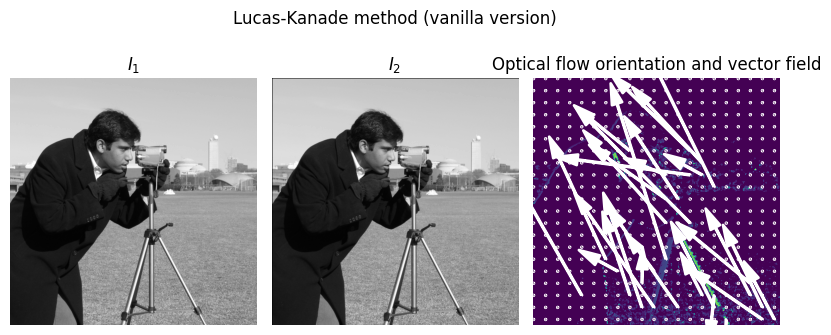

In [13]:
scale = 1 # 1=no change, >1: zoom in, <1: <zoom out (e.g.
rotation = 0 # in degrees, positive or negative for clockwise or counter-clockwise, respectively
translation = (1.0, 1.0) # (tx, ty) in pixel, positive or negative
I1, I2 = get_synthetic_sequence_image_pair('camera', translation=translation, rotation=rotation, scale=scale)
window_size = 3
tau = 0.01
u,v = optical_flow(I1, I2, window_size=window_size, tau=tau)
display_optic_flow(I1, I2, -u, -v, "Lucas-Kanade method (vanilla version)")

The following gives really good results of the optical flow.

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


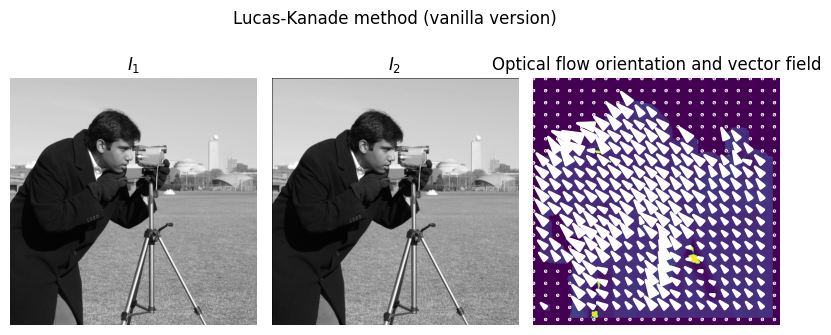

In [14]:
scale = 1 # 1=no change, >1: zoom in, <1: <zoom out (e.g.
rotation = 0 # in degrees, positive or negative for clockwise or counter-clockwise, respectively
translation = (1.0, 1.0) # (tx, ty) in pixel, positive or negative
I1, I2 = get_synthetic_sequence_image_pair('camera', translation=translation, rotation=rotation, scale=scale)
window_size = 30
tau = 0.01
u,v = optical_flow(I1, I2, window_size=window_size, tau=tau)
display_optic_flow(I1, I2, -u, -v, "Lucas-Kanade method (vanilla version)")

And the following with a high window value that takes around half a minute to compute and is not so local.

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


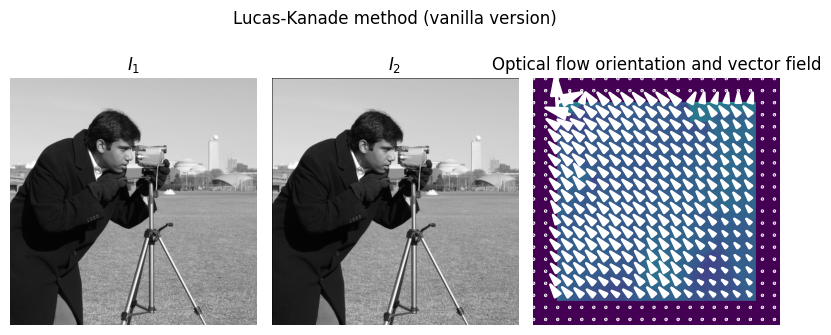

In [15]:
scale = 1 # 1=no change, >1: zoom in, <1: <zoom out (e.g.
rotation = 0 # in degrees, positive or negative for clockwise or counter-clockwise, respectively
translation = (1.0, 1.0) # (tx, ty) in pixel, positive or negative
I1, I2 = get_synthetic_sequence_image_pair('camera', translation=translation, rotation=rotation, scale=scale)
window_size = 100
tau = 0.01
u,v = optical_flow(I1, I2, window_size=window_size, tau=tau)
display_optic_flow(I1, I2, -u, -v, "Lucas-Kanade method (vanilla version)")

# Exercise 9

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


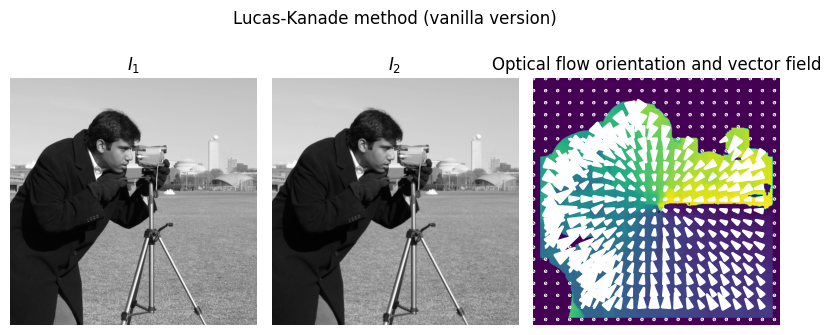

In [16]:
scale = 1.01 # 1=no change, >1: zoom in, <1: <zoom out (e.g.
rotation = 0 # in degrees, positive or negative for clockwise or counter-clockwise, respectively
translation = (0.0, 0.0) # (tx, ty) in pixel, positive or negative
I1, I2 = get_synthetic_sequence_image_pair('camera', translation=translation, rotation=rotation, scale=scale)
window_size = 30
tau = 0.01
u,v = optical_flow(I1, I2, window_size=window_size, tau=tau)
display_optic_flow(I1, I2, -u, -v, "Lucas-Kanade method (vanilla version)")

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


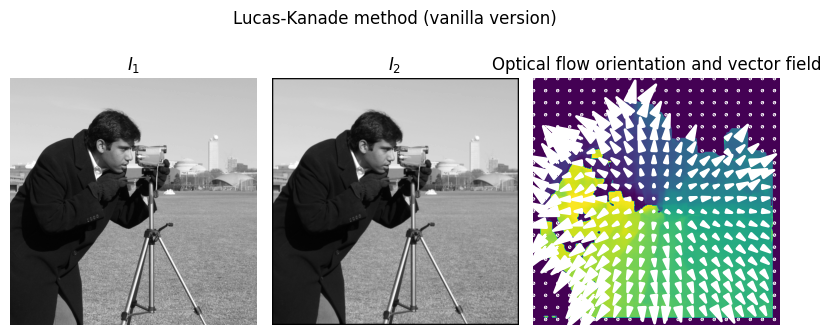

In [17]:
scale = 0.99 # 1=no change, >1: zoom in, <1: <zoom out (e.g.
rotation = 0 # in degrees, positive or negative for clockwise or counter-clockwise, respectively
translation = (0.0, 0.0) # (tx, ty) in pixel, positive or negative
I1, I2 = get_synthetic_sequence_image_pair('camera', translation=translation, rotation=rotation, scale=scale)
window_size = 30
tau = 0.01
u,v = optical_flow(I1, I2, window_size=window_size, tau=tau)
display_optic_flow(I1, I2, -u, -v, "Lucas-Kanade method (vanilla version)")

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


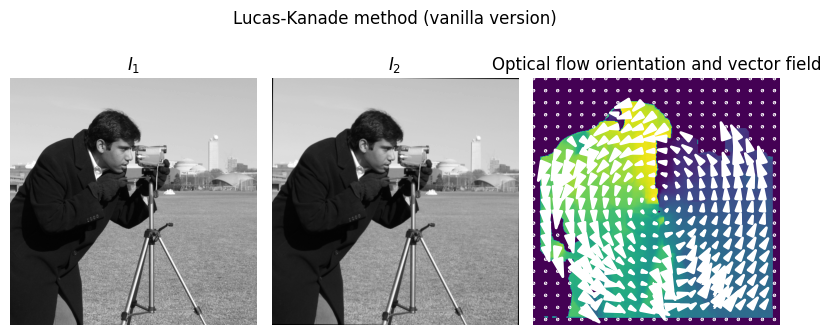

In [18]:
scale = 1 # 1=no change, >1: zoom in, <1: <zoom out (e.g.
rotation = 0.5 # in degrees, positive or negative for clockwise or counter-clockwise, respectively
translation = (0.0, 0.0) # (tx, ty) in pixel, positive or negative
I1, I2 = get_synthetic_sequence_image_pair('camera', translation=translation, rotation=rotation, scale=scale)
window_size = 30
tau = 0.01
u,v = optical_flow(I1, I2, window_size=window_size, tau=tau)
display_optic_flow(I1, I2, -u, -v, "Lucas-Kanade method (vanilla version)")

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


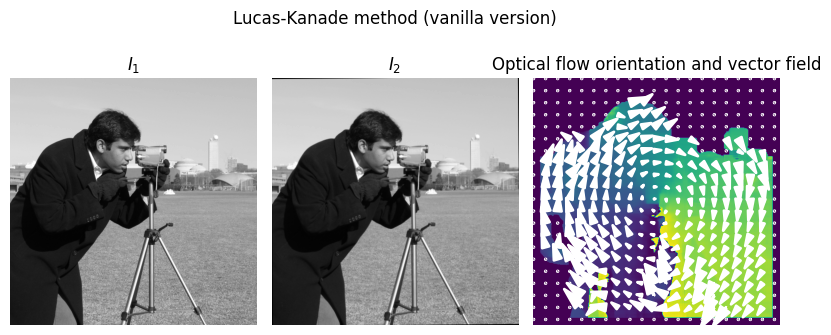

In [19]:
scale = 1 # 1=no change, >1: zoom in, <1: <zoom out (e.g.
rotation = -0.5 # in degrees, positive or negative for clockwise or counter-clockwise, respectively
translation = (0.0, 0.0) # (tx, ty) in pixel, positive or negative
I1, I2 = get_synthetic_sequence_image_pair('camera', translation=translation, rotation=rotation, scale=scale)
window_size = 30
tau = 0.01
u,v = optical_flow(I1, I2, window_size=window_size, tau=tau)
display_optic_flow(I1, I2, -u, -v, "Lucas-Kanade method (vanilla version)")

# Exercise 10

As we can observe the effect of thew window size is the same as described before. The wind size values that for me seem to describe better what is happening between the wo images are between 20 and 50.

In [20]:
def display_only_optic_flow(I1, I2, u, v, title=""):
    fig, ax = plt.subplots(figsize=(8, 4))

    # --- Sequence image sample
    nvec = 20  # Number of vectors to be displayed along each image dimension
    nl, nc = I1.shape
    step = max(nl // nvec, nc // nvec)

    y, x = np.mgrid[:nl:step, :nc:step]
    u_ = u[::step, ::step]
    v_ = v[::step, ::step]

    norm = np.sqrt(u ** 2 + v ** 2)
    angle = np.arctan2(v,u)
    ax.imshow(angle)

    widths = np.linspace(0, 10, u.size)
    ax.quiver(x, y, u_, v_, color='w', units='dots',
               angles='xy', scale_units='xy', lw=2, headaxislength=30, headlength=30, headwidth=15, edgecolors='w')#linewidth=2, edgecolors='w')
    ax.set_axis_off()
    fig.tight_layout()

    plt.title(title)
    plt.show(block=True)

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


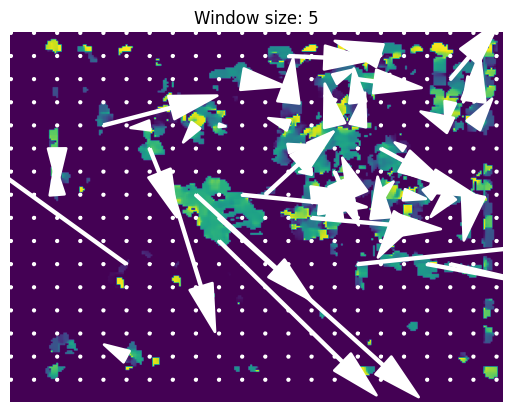

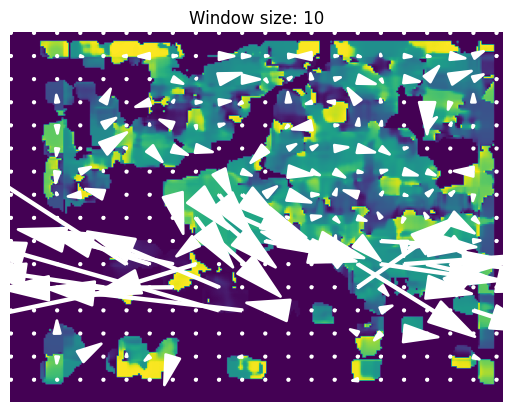

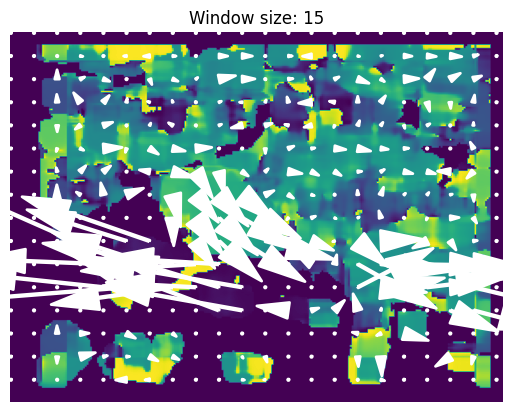

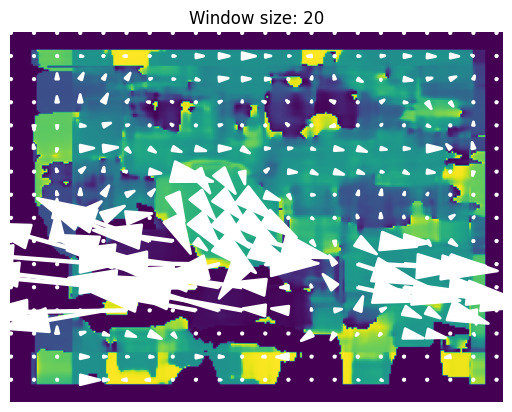

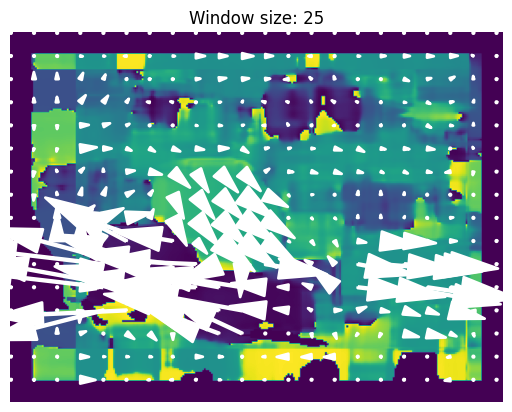

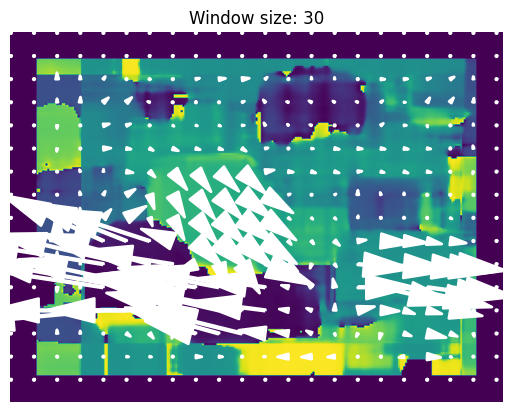

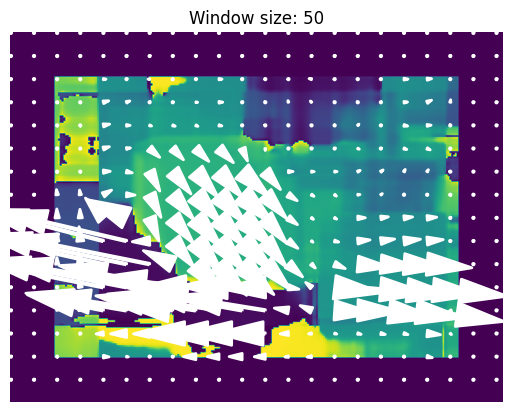

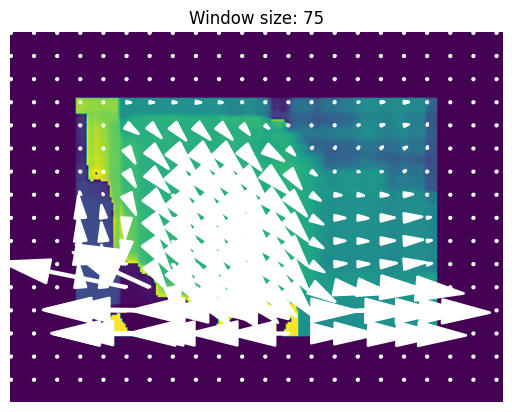

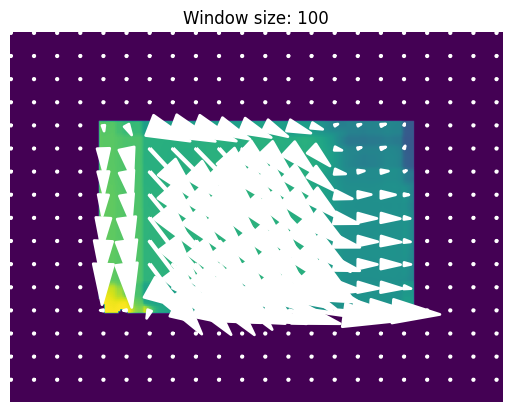

In [21]:
window_size = [5, 10, 15, 20, 25, 30, 50, 75, 100]
for w in window_size:
    I1, I2 = get_real_sequence_image_pair('taxi',30, 31)
    tau = 0.01
    u,v = optical_flow(I1, I2, window_size=w, tau=tau)
    display_only_optic_flow(I1, I2, -u, -v, "Window size: "+ str(w))

For testing the $\tau$ we can assume that the window size is 30. Then we can see that there a lot of difference. What is happening is that the $\tau$ is a discriminator of what consider for computing the optic flow. If it is low, even if a point gives very poor results it is going to be considered for the optical flow. As it increases it will only consider those points that give better result than the ones specified by our threshold.

/tmp/ipykernel_12978/4152559903.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb)
/tmp/ipykernel_12978/4152559903.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[i,j]=nu[0]
/tmp/ipykernel_12978/4152559903.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[i,j]=nu[1]


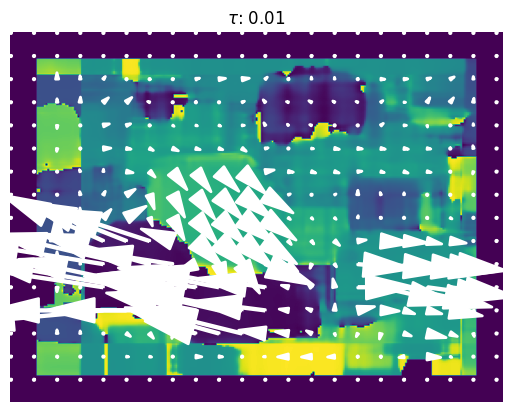

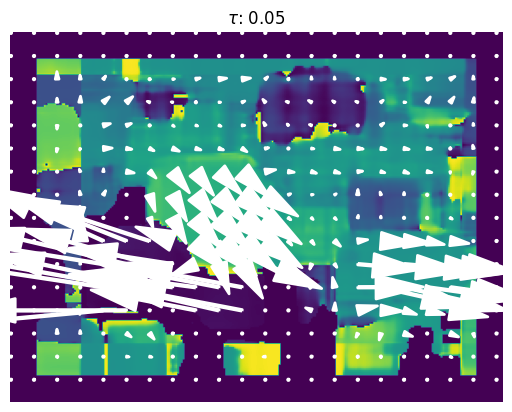

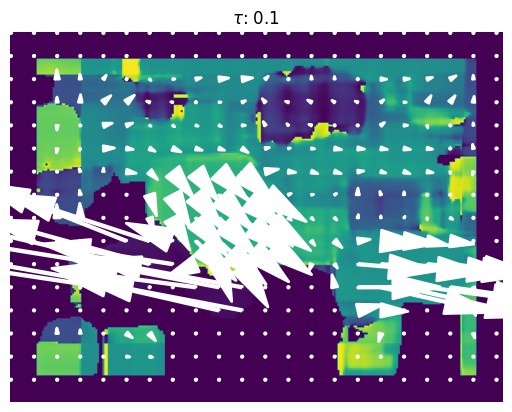

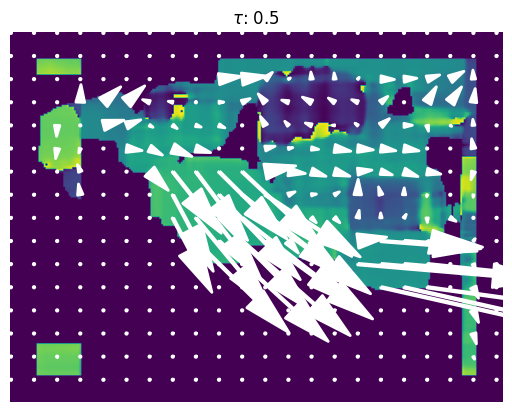

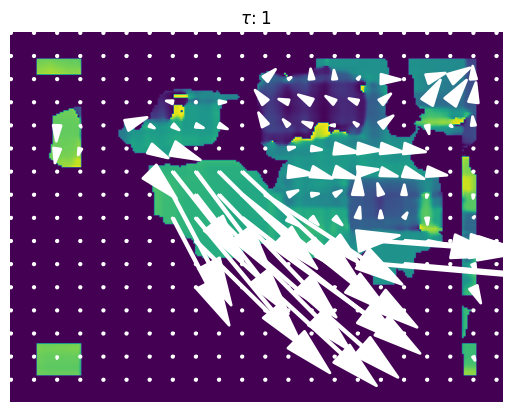

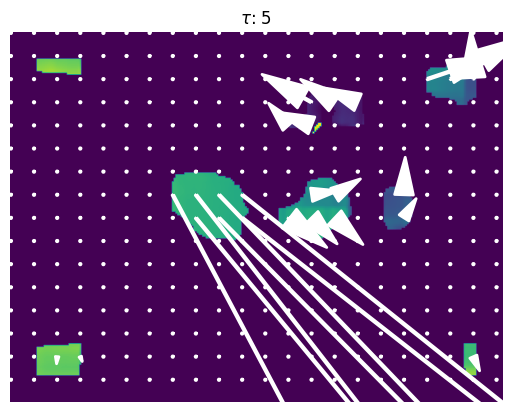

In [22]:
tau = [1e-2, 5e-2, 1e-1, 5e-1, 1, 5]
for t in tau:
    I1, I2 = get_real_sequence_image_pair('taxi',30, 31)
    window_size = 30
    u,v = optical_flow(I1, I2, window_size=window_size, tau=t)
    display_only_optic_flow(I1, I2, -u, -v, "$\\tau$: "+ str(t))